# Cranfield dataset processing

This notebook creates vector space model for documents and queries contained in [Cranfield](http://ir.dcs.gla.ac.uk/resources/test_collections/cran/) collection.

In [2]:
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import matplotlib.pyplot as plt
import matplotlib.style
import numpy as np
matplotlib.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
matplotlib.rcParams.update({'font.size': 18})

Helper functions. `get_top_n()` simply returns indices of top ten relevant documents for each query. `get_precision()` returns precision, recall and f-score for a query (represented by query index and top ten documents retrieved).

In [3]:
def get_top_n(matrix, n=10):
    return np.array([ matrix[i].argsort()[-n:][::-1]+1 for i in range(225)])

def get_precision(query_index, retrieved):
    relevant = []
    with open('cranfield/r/{}.txt'.format(query_index)) as f:
        for line in f:
            relevant.append(int(line))

    tp = 0
    fn = 0
    fp = 0

    for doc in relevant:
        if doc in retrieved:
            tp += 1
        else:
            fn += 1 

    for doc in retrieved:
        if doc not in relevant:
            fp += 1

    p = tp / (tp + fp)
    r = tp / (tp + fn)
    
    if p == 0 or r == 0:
        f = 0
    else:
        f = 2 * ((p * r)/(p + r))
    
    return p, r, f

def get_prf_dict(top_retrieved):
    prf = {
        'p' : np.array([0.] * len(top_retrieved)),
        'r' : np.array([0.] * len(top_retrieved)),
        'f' : np.array([0.] * len(top_retrieved)),
    }
    
    for idx, top in enumerate(top_retrieved):
        prf['p'][idx] = get_precision(idx + 1, top)[0]
        prf['r'][idx] = get_precision(idx + 1, top)[1]
        prf['f'][idx] = get_precision(idx + 1, top)[2]
    
    return prf

Here we prepare corpus of documents and queries for processing. Note that `corpus[:1400]` contains documents and `corpus[1400:]` contains queries.

In [4]:
corpus = []

for d in range(1400):
    f = open("cranfield/d/"+str(d+1)+".txt")
    corpus.append(f.read())
    f.close()
for q in range(225):
    f = open("cranfield/q/"+str(q+1)+".txt")
    corpus.append(f.read())
    f.close()

Initialization of different vectorizers we are going to use to create vector space model.
* TFIDF vectorizer -- calculates [TFIDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) score for each document or query
* Count vectorizer -- counts term in each document or query
* Binary vectorizer -- 1 if term is present in document/query, 0 otherwise

In [5]:
tfidf_vectorizer = TfidfVectorizer()
count_vectorizer = CountVectorizer()
binary_vectorizer = CountVectorizer(binary=True)

Matrices with dimensions (1625 -- number of documents and queries, 20679 -- total number of terms) for each vectorizer. Matrix rows are vector of given vector space models (each row represent document or query).

In [6]:
tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)
count_matrix = count_vectorizer.fit_transform(corpus)
bin_matrix = binary_vectorizer.fit_transform(corpus)

Calculate similarity between queries and documents using given vector space model (TFIDF, count, binary) and distance measure (cosine similiarity, euclidean distance). Each matrix has dimensions (225, 1400), each element represents similarity betweent one query and one document.

In [7]:
r_tfidf_cos = np.array(cosine_similarity(tfidf_matrix[1400:], tfidf_matrix[:1400]))
r_tfidf_euc = np.array(pairwise_distances(tfidf_matrix[1400:], tfidf_matrix[:1400]))

r_count_cos = np.array(cosine_similarity(count_matrix[1400:], count_matrix[:1400]))
r_count_euc = np.array(pairwise_distances(count_matrix[1400:], count_matrix[:1400]))

r_bin_cos = np.array(cosine_similarity(bin_matrix[1400:], bin_matrix[:1400]))
r_bin_euc = np.array(pairwise_distances(bin_matrix[1400:], bin_matrix[:1400]))

Get indices of 10 most relevant documents for each query using given vector space model and distance measure.

In [8]:
top_relevant_tfidf_cos = get_top_n(r_tfidf_cos)
top_relevant_tfidf_euc = get_top_n(r_tfidf_euc)

top_relevant_count_cos = get_top_n(r_count_cos)
top_relevant_count_euc = get_top_n(r_count_euc)

top_relevant_bin_cos = get_top_n(r_bin_cos)
top_relevant_bin_euc = get_top_n(r_bin_euc)


Now we can use top 10 matching documents for each query to calculate methods precision, recall and F-score. These values are calculated by comparing query's top 10 documents to the list of actually relevant documents. These lists (one for each query) come with Cranfield collection and can be found in `cranfield/r` folder.

In [9]:
tfidf_cos_prf = get_prf_dict(top_relevant_tfidf_cos)
tfidf_euc_prf = get_prf_dict(top_relevant_tfidf_euc)

count_cos_prf = get_prf_dict(top_relevant_count_cos)
count_euc_prf = get_prf_dict(top_relevant_count_euc)

bin_cos_prf = get_prf_dict(top_relevant_bin_cos)
bin_euc_prf = get_prf_dict(top_relevant_bin_euc)

When we have these values, we can compare different distances and vector models. As you can see, precision can vary a lot, depending on the query, different vector space models however yield similar results.

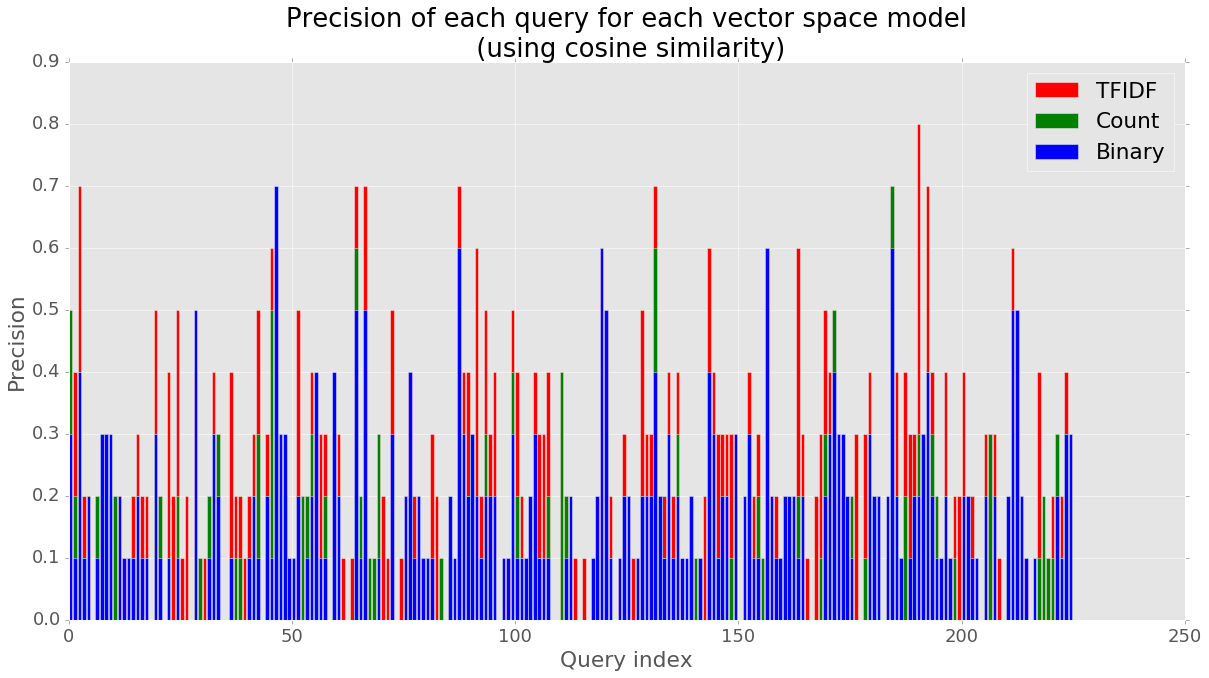

In [10]:
r = np.arange(225)
plt.bar(r, tfidf_cos_prf['p'], color='r', label='TFIDF')
plt.bar(r, count_cos_prf['p'], color='g', label='Count')
plt.bar(r, bin_cos_prf['p'], color='b', label='Binary')

plt.legend()

plt.title('Precision of each query for each vector space model\n (using cosine similarity)')
plt.xlabel('Query index')
plt.ylabel('Precision')
plt.show()

On the other hand, when usin euclidean distance instead of cosine similarity, results are much worse (barely any query yields desired results).

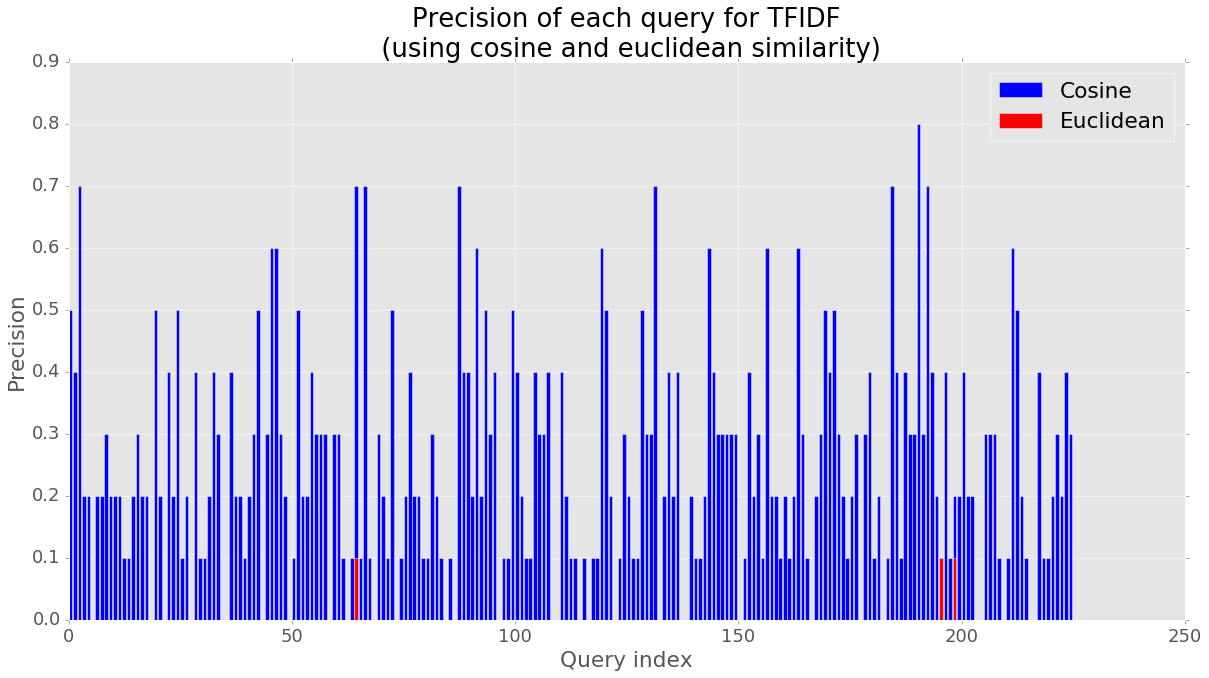

In [11]:
plt.bar(r,tfidf_cos_prf['p'], label='Cosine', color='b')
plt.bar(r,tfidf_euc_prf['p'], label='Euclidean', color='r')

plt.legend()

plt.title('Precision of each query for TFIDF\n (using cosine and euclidean similarity)')
plt.xlabel('Query index')
plt.ylabel('Precision')
plt.show()

Precision, recall and fscores for each method are shown in following "table", in format (mean, maximum). We can see that TFIDF

In [27]:
eval_scores = {}
for method in [('TFIDF', tfidf_cos_prf, tfidf_euc_prf), ('Count', count_cos_prf, count_euc_prf), ('Binary', bin_cos_prf, bin_euc_prf)]:
    eval_scores[method[0]] = {}
    for metric in ['p', 'r', 'f']:
        eval_scores[method[0]][metric] = {}
        
        eval_scores[method[0]][metric]['cos'] = (method[1][metric].mean(), method[1][metric].max())
        eval_scores[method[0]][metric]['euc'] = (method[2][metric].mean(), method[2][metric].max())

import pprint

pprint.pprint(eval_scores)

{'Binary': {'f': {'cos': (0.16497864172485072, 0.70588235294117641),
                  'euc': (0.0056656051990731397, 0.11764705882352941)},
            'p': {'cos': (0.14888888888888888, 0.69999999999999996),
                  'euc': (0.0057777777777777784, 0.10000000000000001)},
            'r': {'cos': (0.22140182421189858, 1.0),
                  'euc': (0.005783679283679284, 0.14285714285714285)}},
 'Count': {'f': {'cos': (0.13938238148011289, 0.69999999999999996),
                 'euc': (0.006097703964505239, 0.125)},
           'p': {'cos': (0.12888888888888889, 0.69999999999999996),
                 'euc': (0.0062222222222222227, 0.10000000000000001)},
           'r': {'cos': (0.17788354266755035, 1.0),
                 'euc': (0.0063023581356914686, 0.16666666666666666)}},
 'TFIDF': {'f': {'cos': (0.26340163852421816, 0.82352941176470584),
                 'euc': (0.0011961900291419742, 0.10526315789473685)},
           'p': {'cos': (0.2408888888888889, 0.80000000000000004),
